In [ ]:
from gensim.models.word2vec import Word2Vec
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy
import json
import pandas as pd
import seaborn as sns
import sys
sys.path.append("/home/george/Dev/embeddings/")
from src.utils.misc import wordcount
from src.utils.evaluation import evaluate
from src.utils.dataloader import Dataset
from anbani.nlp.preprocessing import sentence_tokenize
sns.set_theme()

# Word2Vec



In [2]:
class RustaveliTrainer:
    def __init__(self, 
        dataset_path="../../data/rustaveli/v1/vef_corpus_chapter.txt", 
        related_queries_path="../../data/rustaveli/test/related-terms.json",
        analogy_queries_path="../../data/rustaveli/test/analogies.json"
    ) -> None:

        self.SET_PARAMS = {
            # TRAIN FULL DICT
            "max_final_vocab": 20000,
            "min_count": 0,
            "seed" : 42
        }

        self.tokens = Dataset(dataset_path).load()
        # _, wstats, _ = wordcount(self.tokens)
        # print(wstats)
        self.related_queries = json.loads(open(related_queries_path, "r").read())
        self.analogy_queries = json.loads(open(analogy_queries_path, "r").read())
        self.current_epoch = 0
        self.should_stop = False


    def evaluate_model(self, model=None):
        if model == None:
            return evaluate(self.analogy_queries, self.related_queries, self.model)
        return evaluate(self.analogy_queries, self.related_queries, model)
            

    def train(self, params={}, callback=None, total_epochs=250):

        self.model = Word2Vec(
            self.tokens,
            epochs=1,
            workers=6,
            **self.SET_PARAMS,
            **params,
        )

        self.current_epoch += 1

        self.total_epochs = total_epochs
        pbar = tqdm(range(self.total_epochs))

        study_name = "rustaveli-word2vec"
        self.best_score = 0
        self.results = []


        for e in pbar:
            self.model.train(self.tokens, epochs=1, total_examples=self.model.corpus_count)
            self.current_epoch += 1

            self.score, details = self.evaluate_model()
            
            self.results.append({
                "epoch": 1,
                "score": self.score,
                "eval_analogy": details['analogy'],
                "eval_related": details['related'],
                "params": params,
                "study": study_name
            })

            self.best_score = max(self.best_score, self.score)
            if self.score == self.best_score:
                pbar.set_description_str(
                    f"[{len(self.model.wv.key_to_index)} x {params['vector_size']}] => Best Epoch ⏳️{e}")
                self.best_model = copy.deepcopy(self.model)

            pbar.set_postfix_str(
                f"🟢 {self.best_score*100:.2f}% -> 🟡 {self.score*100:.2f}% | 🅰 {details['analogy']*100:.2f}% | 🆁 {details['related']*100:.2f}%")

            if callback: callback(self)
            if self.should_stop: break


    def plot_results(self):
        res = pd.DataFrame(self.results)
        # res.to_csv("rustaveli_word2vec_train.csv", index=None)

        print(res.iloc[0].params)
        plt.figure(figsize=(15,4), dpi=300)
        return sns.lineplot(data=res[['score', 'eval_analogy', 'eval_related']])

In [3]:
# r = RustaveliTrainer()
# r.train()

# Understanding Hyperparameters



```python
vector_size=100 # Wordvector dimension i.e. model's scale to learn various topics

alpha=0.025 # Initial learning rate 
# lower=slower training, higher=increased chance of overshooting

window=5 # Maximum distance between the current and predicted word within a sentence.
min_count=5 # Ignores all words with total frequency lower than this.
 
sample=1e-3 # The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).
seed=42 # .

sg=0 # Training algorithm: 1=skip-gram, 0=cbow
# cbow - looks for the word's entire context (surrounding words). Faster to train and offers higher accuracy with frequent words. 
# skip-gram - predicts based on a single nearby word. Works great with smaller datasets and rare words. 

hs=0 # 1=Hierarchical Softmax, 0=Negative Sampling for non-zero negative param
# Hierarchical Softmax - efficient version of softmax. Better for infrequent words. 
# Negative Sampling - Better for frequent words and lower dimensional vectors. 

negative=5 # Usually between 5-20. 
ns_exponent=0.75 # The exponent used to shape the negative sampling distribution. 
cbow_mean=1 # If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.

shrink_windows=True # If True, the effective window size is uniformly sampled from  [1, w]
```


In [4]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
import logging

optuna.logging.get_logger("optuna").addHandler(logging.FileHandler("optuna.log", mode="a"))

study_name = "rustaveli-word2vec"
storage_name = "sqlite:///optuna.db".format(study_name)

study = optuna.create_study(
    study_name=study_name, 
    storage=storage_name, 
    load_if_exists=True,
    direction='maximize',
    pruner=optuna.pruners.PatientPruner(None, patience=50)
)

/tmp/ipykernel_205289/2510340220.py:21: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner=optuna.pruners.PatientPruner(None, patience=50)

[I 2022-06-18 11:55:03,763] A new study created in RDB with name: rustaveli-word2vec


In [5]:
def objective(trial):
    # Define parameter searchspace
    params = {
        # DEFAULTS
        "alpha" : 0.025,
        "window": 5,
        "vector_size": 100,

        # TUNING
        "hs" : 1,
        "negative" : 0,

        "vector_size": trial.suggest_categorical("vector_size", [100,300]),
        "alpha" : trial.suggest_categorical("alpha", [0.025, 0.01, 0.05]),
        "sg" : trial.suggest_categorical("sg", [0,1]),
        "window": trial.suggest_categorical("window", [1,2,5,10,20,50,100,200]),
        "shrink_windows" : trial.suggest_categorical("shrink_windows", [True, False]),
    }

    # Callback to prune unpromising trials
    def optuna_callback(model):
        trial.report(model.score, step=model.current_epoch)
        if trial.should_prune():
            model.should_stop = True


    r = RustaveliTrainer()

    r.train(
        params=params,
        callback=optuna_callback    
    )


    # Choose the best epoch as representative of a trial
    intermediate = trial.study.trials[trial.number].intermediate_values
    best_optuna_epoch = max(intermediate, key=intermediate.get)
    best_optuna_score = intermediate[best_optuna_epoch]
    trial.set_user_attr("best_optuna_epoch", best_optuna_epoch)

    # print(f"Trial: {trial.number} // {trial.params} params.\nBest Score:{best_optuna_score:.2f}. Best Epoch:{best_optuna_epoch}/{len(intermediate)}")
    return best_optuna_score


study.optimize(objective, n_trials=100)

[15013 x 100] => Best Epoch ⏳️0:  20%|██        | 51/250 [00:32<02:07,  1.56it/s, 🟢 79.41% -> 🟡 67.65% | 🅰 68.18% | 🆁 67.12%]
[I 2022-06-18 11:55:37,072] Trial 0 finished with value: 0.7941333333333334 and parameters: {'vector_size': 100, 'alpha': 0.05, 'sg': 1, 'window': 5, 'shrink_windows': False}. Best is trial 0 with value: 0.7941333333333334.
[15013 x 300] => Best Epoch ⏳️27:  31%|███       | 78/250 [00:45<01:41,  1.70it/s, 🟢 68.07% -> 🟡 58.59% | 🅰 66.61% | 🆁 50.58%]
[I 2022-06-18 11:56:23,628] Trial 1 finished with value: 0.6807166666666666 and parameters: {'vector_size': 300, 'alpha': 0.05, 'sg': 0, 'window': 20, 'shrink_windows': True}. Best is trial 0 with value: 0.7941333333333334.
[15013 x 300] => Best Epoch ⏳️8:  24%|██▎       | 59/250 [00:35<01:55,  1.65it/s, 🟢 75.07% -> 🟡 63.28% | 🅰 65.29% | 🆁 61.27%]
[I 2022-06-18 11:57:00,062] Trial 2 finished with value: 0.7506833333333334 and parameters: {'vector_size': 300, 'alpha': 0.05, 'sg': 0, 'window': 50, 'shrink_windows': True

# Visualization

In [6]:
best = sorted(study.trials, key=lambda x: 0 if not x.value else x.value, reverse=True)
pd.DataFrame(
    list(map(lambda x: {**x.params, 'value': x.value}, 
    best[:200]))
).style.highlight_max(color = 'lightgreen', axis = 0)

,vector_size,alpha,sg,window,shrink_windows,value
0,100,0.010000,0,200,True,0.879583
1,100,0.010000,0,200,True,0.879583
2,100,0.010000,0,200,True,0.879583
3,100,0.010000,0,200,True,0.879583
4,100,0.010000,0,200,True,0.879583
5,100,0.010000,0,200,True,0.879583
6,100,0.010000,0,200,True,0.879583
7,100,0.010000,0,200,True,0.879583
8,100,0.010000,0,200,True,0.879583
9,100,0.010000,0,200,True,0.879583


In [7]:
plot_optimization_history(study)


In [8]:
plot_intermediate_values(study)


In [9]:
plot_parallel_coordinate(study)


In [10]:
plot_contour(study)


In [11]:
plot_contour(study, params=["vector_size", "window"])

In [12]:
plot_slice(study)

In [13]:
plot_param_importances(study)


In [14]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [15]:
plot_edf(study)


# Best Trial

In [16]:
study.best_trial.value

0.8795833333333334

In [17]:
study.best_trial.params

{'alpha': 0.01,
 'sg': 0,
 'shrink_windows': True,
 'vector_size': 100,
 'window': 200}

# Retrain best trial

[15013 x 100] => Best Epoch ⏳️105: 100%|██████████| 500/500 [04:55<00:00,  1.69it/s, 🟢 90.63% -> 🟡 77.19% | 🅰 69.44% | 🆁 84.94%]

{'alpha': 0.01, 'sg': 0, 'shrink_windows': True, 'vector_size': 100, 'window': 200}


<AxesSubplot:>

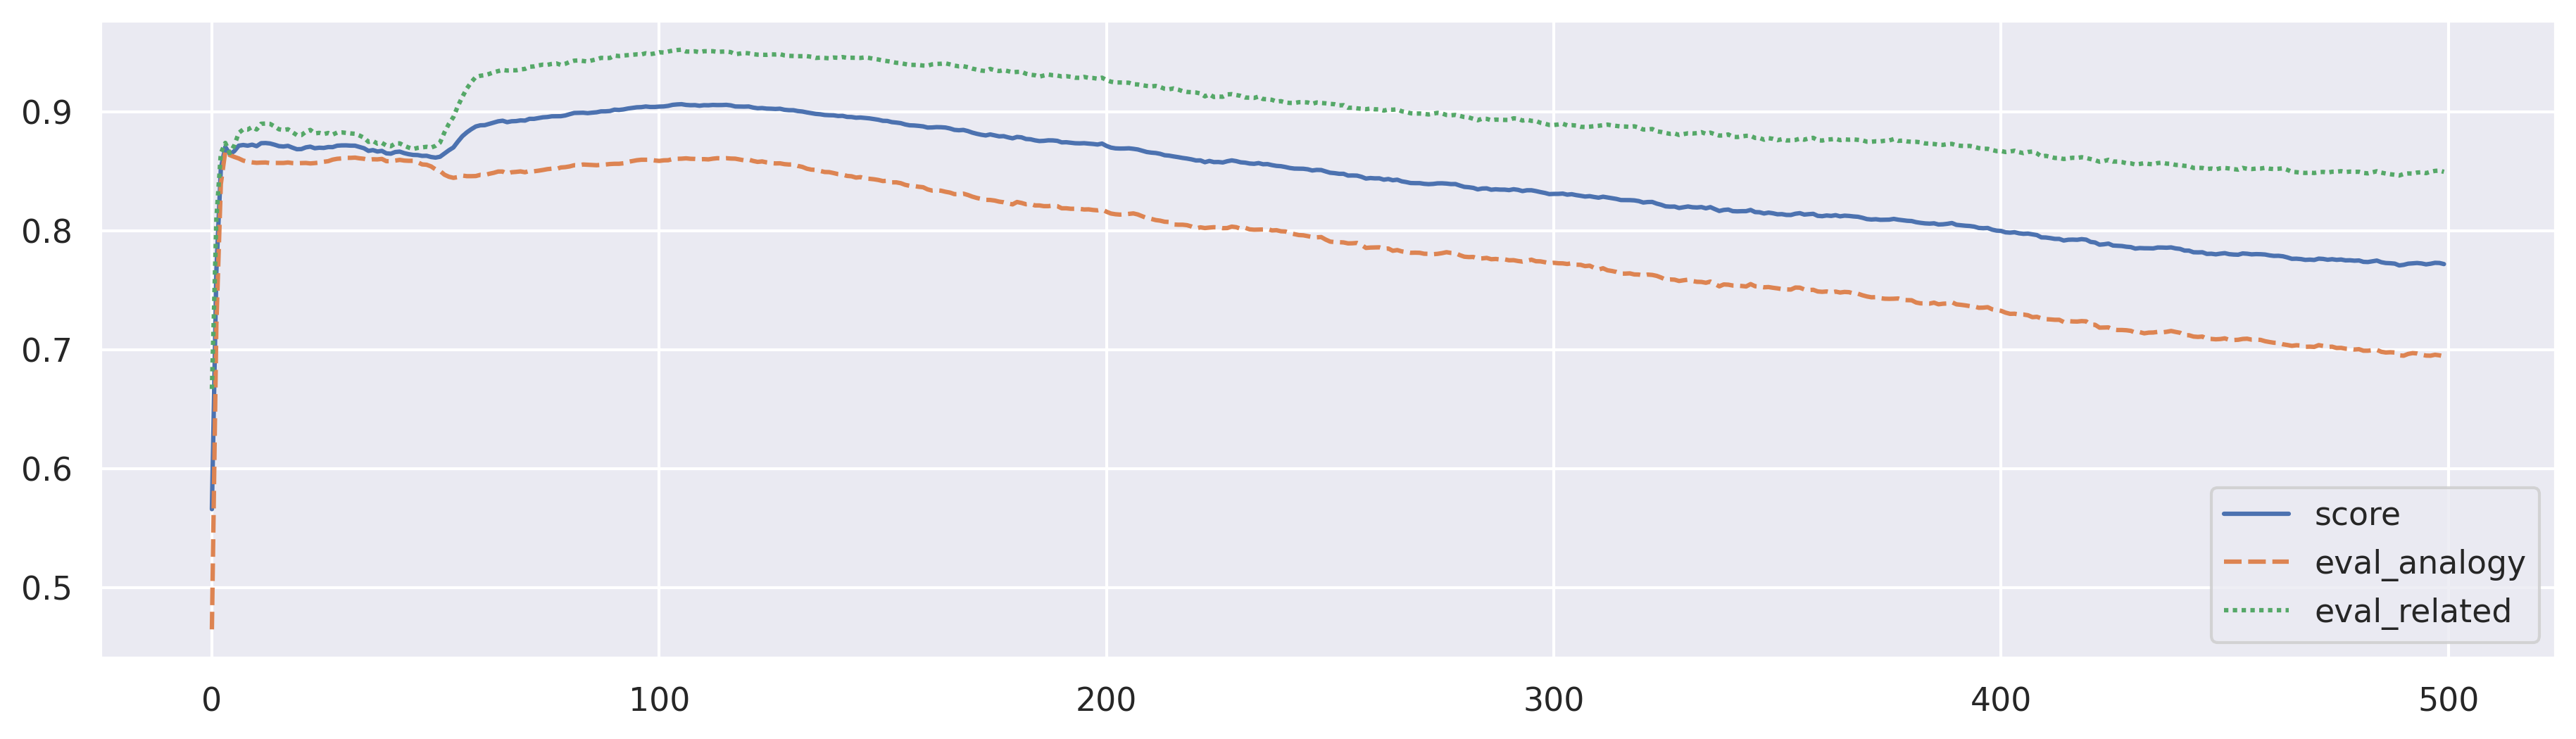

In [18]:
b = RustaveliTrainer()
b.train(
    params=study.best_trial.params,
    total_epochs=500
)

b.plot_results()

# Generate Tensorboard Projector artifacts

In [19]:
from projector import generate_tensors

generate_tensors(b.best_model, 'ვეფხისტყაოსანი')

100%|██████████| 15013/15013 [00:00<00:00, 18403.48it/s, ქმნილთა]    




{
    "embeddings": [
      {
        "tensorName": ვეფხისტყაოსანი,
        "tensorShape": [15013, 100],
        "tensorPath": "../../artifacts/web/ვეფხისტყაოსანი_tensors.bytes",
        "metadataPath": "../../artifacts/web/ვეფხისტყაოსანი_labels.tsv"
      }
    ],
  }
